In [26]:
import numpy as np
import random

num_entities = 100
num_validators = 50000
num_slots = 30000
fixed_reward = 0.025
sigma_mev_reward = 1
split_threshold = 32
num_builders = 100
threshold_percentage = 0.2

# Add the feature flags here
rational_choice_enabled = False
boost_enabled = False

def generate_distribution(desired_median, num_points=210_000, max_values=[692, 550, 198], num_points_upper=35_000, lower_range=(0, 0.13)):
    # Calculate the mean based on the desired median
    mu = np.log(desired_median)

    # Generate a lognormal distribution with a long tail
    dist = np.random.lognormal(mean=mu, sigma=1.5, size=num_points)

    # Truncate the distribution between 0 and 0.13 ETH
    truncated_dist = dist[(dist >= lower_range[0]) & (dist <= lower_range[1])]

    # Calculate the number of data points we need to add to the upper part
    num_points_to_add = num_points - len(truncated_dist)

    # Add the remaining data points with specific maximum values
    additional_points = []
    for max_value in max_values:
        points = np.linspace(lower_range[1], max_value, num_points_to_add // len(max_values))
        additional_points.extend(points)

    # Combine the truncated lower part and the additional upper part
    final_dist = np.concatenate([truncated_dist, additional_points])

    return final_dist

builder_mev_median_rewards = [0.13] + [0.09]*2 + [0.065]*(num_builders-3)

# Generate distributions for each builder upfront
builder_distributions = [generate_distribution(median) for median in builder_mev_median_rewards]


# Create validator_entity_mapping, builder_entity_mapping and initialize rewards
validator_entity_mapping = [i % num_entities for i in range(num_validators)]
builder_entity_mapping = [i % num_entities for i in range(num_builders)]
validator_rewards = np.zeros(num_validators)
entity_rewards = np.zeros(num_entities)
builder_profits = np.zeros(num_builders)

# Create lists of validators per entity
validators_per_entity = [[] for _ in range(num_entities)]
for validator_idx, entity in enumerate(validator_entity_mapping):
    validators_per_entity[entity].append(validator_idx)

# If boost_enabled, choose a random entity to receive a 10% value boost
boosted_entity = random.randrange(num_entities) if boost_enabled else None
print(f"Boosted entity: {boosted_entity}")

# Run the simulation
for i in range(num_slots):

    if i%100 == 0:
        print(i)

    # Calculate block values for each builder using pre-generated distributions
    block_values = [np.random.choice(dist) for dist in builder_distributions]

    # Select a random validator
    chosen_validator = random.randrange(num_validators)

    # Apply a 10% value boost to the boosted entity's block
    if boost_enabled and boosted_entity is not None:
        entity_builder = builder_entity_mapping.index(boosted_entity)
        block_values[entity_builder] *= 1.1

    # Choose the highest block value
    chosen_builder = np.argmax(block_values)
    mev_reward = block_values[chosen_builder]

    validator_entity = validator_entity_mapping[chosen_validator]

    if rational_choice_enabled:
        # Choose the block that maximizes profit for the validator's entity
        entity_builder = builder_entity_mapping.index(validator_entity)
        entity_builder_value = block_values[entity_builder]
        entity_builder_profit = entity_builder_value * 0.95

        # Find the block that maximizes the validator's entity profit
        best_profit = entity_builder_profit
        best_builder = entity_builder

        for idx, value in enumerate(block_values):
            profit = value * 0.95 if idx == entity_builder else value * 0.9

            if profit > best_profit:
                best_profit = profit
                best_builder = idx

        chosen_builder = best_builder
        mev_reward = block_values[chosen_builder]

    # Share the reward between the validator and the builder
    validator_share = mev_reward * 0.95
    builder_share = mev_reward * 0.05
    builder_profits[chosen_builder] += builder_share

    # Assign rewards
    block_reward = fixed_reward
    total_reward = block_reward + mev_reward

    validator_rewards[chosen_validator] += total_reward
    entity_rewards[validator_entity_mapping[chosen_validator]] += total_reward

    # Check if we need to spawn a new validator for any entity
    for entity_idx in range(num_entities):
        if entity_rewards[entity_idx] >= split_threshold:
            # Spawn a new validator for this entity
            num_validators += 1
            validator_entity_mapping.append(entity_idx)
            validator_rewards = np.append(validator_rewards, 0)
            validators_per_entity[entity_idx].append(num_validators - 1)

            # Deduct the rewards used to spawn the new validator from the existing validators
            to_deduct = split_threshold
            for validator_idx in validators_per_entity[entity_idx]:
                if to_deduct > 0:
                    deduct_amount = min(validator_rewards[validator_idx], to_deduct)
                    validator_rewards[validator_idx] -= deduct_amount
                    entity_rewards[entity_idx] -= deduct_amount
                    to_deduct -= deduct_amount

# Print the top and bottom 20 validator stakes
sorted_indices = np.argsort(validator_rewards)
print("Top 20 validator stakes:")
for idx in sorted_indices[-20:]:
    print(f"Validator {idx}: {validator_rewards[idx]}")

print("Bottom 20 validator stakes:")
for idx in sorted_indices[:20]:
    print(f"Validator {idx}: {validator_rewards[idx]}")

# Count validators per entity
validators_count_per_entity = [len(validators) for validators in validators_per_entity]

# Calculate the total value each entity controls
entity_values = np.array(validators_count_per_entity) * 32 + entity_rewards

# Print the results
print("Validators per entity:")
for i in range(num_entities):
    print(f"Entity {i}: {validators_count_per_entity[i]}")

print("Total value each entity controls:")
for i in range(num_entities):
    print(f"Entity {i}: {entity_values[i]}")

# Rank entities by their total value
sorted_entity_indices = np.argsort(entity_values)[::-1]
print("Entities ranked by total value:")
for rank, idx in enumerate(sorted_entity_indices, start=1):
    print(f"Rank {rank}: Entity {idx} with total value {entity_values[idx]}")

# Rank builders by their total profits
sorted_builder_indices = np.argsort(builder_profits)[::-1]
print("Builders ranked by total profits:")
for rank, idx in enumerate(sorted_builder_indices, start=1):
    print(f"Rank {rank}: Builder {idx} with total profits {builder_profits[idx]}")


Boosted entity: None
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100

In [27]:
for idx in sorted_indices:
    print(f"Validator {idx}: {validator_rewards[idx]}")

Validator 0: 0.0
Validator 428247: 0.0
Validator 428248: 0.0
Validator 428249: 0.0
Validator 428250: 0.0
Validator 428251: 0.0
Validator 428252: 0.0
Validator 428253: 0.0
Validator 428254: 0.0
Validator 428255: 0.0
Validator 428256: 0.0
Validator 428257: 0.0
Validator 428258: 0.0
Validator 428259: 0.0
Validator 428260: 0.0
Validator 428261: 0.0
Validator 428246: 0.0
Validator 428245: 0.0
Validator 428244: 0.0
Validator 428243: 0.0
Validator 428227: 0.0
Validator 428228: 0.0
Validator 428229: 0.0
Validator 428230: 0.0
Validator 428231: 0.0
Validator 428232: 0.0
Validator 428233: 0.0
Validator 428262: 0.0
Validator 428234: 0.0
Validator 428236: 0.0
Validator 428237: 0.0
Validator 428238: 0.0
Validator 428239: 0.0
Validator 428240: 0.0
Validator 428241: 0.0
Validator 428242: 0.0
Validator 428235: 0.0
Validator 428226: 0.0
Validator 428263: 0.0
Validator 428265: 0.0
Validator 428286: 0.0
Validator 428287: 0.0
Validator 428288: 0.0
Validator 428289: 0.0
Validator 428290: 0.0
Validator 42829

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validator 86595: 0.0
Validator 86596: 0.0
Validator 86597: 0.0
Validator 86598: 0.0
Validator 86599: 0.0
Validator 86600: 0.0
Validator 86593: 0.0
Validator 86621: 0.0
Validator 86622: 0.0
Validator 86623: 0.0
Validator 86644: 0.0
Validator 86645: 0.0
Validator 86646: 0.0
Validator 86647: 0.0
Validator 86648: 0.0
Validator 86649: 0.0
Validator 86650: 0.0
Validator 86643: 0.0
Validator 86651: 0.0
Validator 86653: 0.0
Validator 86654: 0.0
Validator 86655: 0.0
Validator 86656: 0.0
Validator 86657: 0.0
Validator 86658: 0.0
Validator 86659: 0.0
Validator 86652: 0.0
Validator 86738: 0.0
Validator 86642: 0.0
Validator 86640: 0.0
Validator 86624: 0.0
Validator 86625: 0.0
Validator 86626: 0.0
Validator 86627: 0.0
Validator 86628: 0.0
Validator 86629: 0.0
Validator 86630: 0.0
Validator 86641: 0.0
Validator 86631: 0.0
Validator 86633: 0.0
Validator 86634: 0.0
Validator 86635: 0.0
Validator 86636: 0.0
Validator 86637: 0.0
Validator 86638: 0.0
Validator 86639: 0.0
Validator 86632: 0.0
Validator 872

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Validator 234343: 0.0
Validator 234342: 0.0
Validator 234341: 0.0
Validator 234325: 0.0
Validator 234326: 0.0
Validator 234327: 0.0
Validator 234328: 0.0
Validator 234329: 0.0
Validator 234330: 0.0
Validator 234331: 0.0
Validator 234360: 0.0
Validator 234332: 0.0
Validator 234334: 0.0
Validator 234335: 0.0
Validator 234336: 0.0
Validator 234337: 0.0
Validator 234338: 0.0
Validator 234339: 0.0
Validator 234340: 0.0
Validator 234333: 0.0
Validator 234324: 0.0
Validator 234361: 0.0
Validator 234363: 0.0
Validator 234384: 0.0
Validator 234385: 0.0
Validator 234386: 0.0
Validator 234387: 0.0
Validator 234388: 0.0
Validator 234389: 0.0
Validator 234390: 0.0
Validator 234391: 0.0
Validator 234392: 0.0
Validator 234393: 0.0
Validator 234394: 0.0
Validator 234395: 0.0
Validator 234396: 0.0
Validator 234397: 0.0
Validator 234398: 0.0
Validator 234383: 0.0
Validator 234382: 0.0
Validator 234381: 0.0
Validator 234380: 0.0
Validator 234364: 0.0
Validator 234365: 0.0
Validator 234366: 0.0
Validator

In [28]:
# Calculate associated builder rewards for each entity
entity_builder_rewards = np.zeros(num_entities)
for builder_idx, builder_reward in enumerate(builder_profits):
    entity_builder_rewards[builder_entity_mapping[builder_idx]] += builder_reward

# Calculate the staked ETH for each entity
staked_eth_per_entity = np.array(validators_count_per_entity) * 32

# Calculate the total rewards for each entity
total_entity_rewards = entity_rewards + entity_builder_rewards + staked_eth_per_entity

# Rank entities by total rewards
sorted_total_entity_indices = np.argsort(total_entity_rewards)[::-1]

# Print the results
print("Entities ranked by total rewards including staked ETH:")
for rank, idx in enumerate(sorted_total_entity_indices, start=1):
    print(f"Rank {rank}: Entity {idx} with validator rewards {entity_rewards[idx]}, builder rewards {entity_builder_rewards[idx]}, staked ETH {staked_eth_per_entity[idx]}, and total rewards {total_entity_rewards[idx]}")


Entities ranked by total rewards including staked ETH:
Rank 1: Entity 49 with validator rewards 0.17815707729016594, builder rewards 8429.622430824436, staked ETH 325056, and total rewards 333485.80058790173
Rank 2: Entity 43 with validator rewards 0.3763669960457037, builder rewards 9010.82923078461, staked ETH 296064, and total rewards 305075.20559778064
Rank 3: Entity 67 with validator rewards 31.967957178262623, builder rewards 9291.796235866661, staked ETH 291712, and total rewards 301035.7641930449
Rank 4: Entity 74 with validator rewards 16.663939048151065, builder rewards 8898.834593619269, staked ETH 287552, and total rewards 296467.4985326674
Rank 5: Entity 29 with validator rewards 4.097835996730964, builder rewards 10336.273671487876, staked ETH 284128, and total rewards 294468.3715074846
Rank 6: Entity 42 with validator rewards 23.72318801582344, builder rewards 9120.057353332746, staked ETH 279616, and total rewards 288759.78054134856
Rank 7: Entity 37 with validator rewa


Summary Statistics:
Number of validators: 642554
Average stake: 0.016453767816327607
Median stake: 0.0
Standard deviation of stake: 2.572359334401566

Entity Statistics:
  Entity    Validators    Total Value
--------  ------------  -------------
       0          6091       194929
       1          7761       249452
       2          4233       135465
       3          7829       250557
       4          8142       260799
       5          5006       160594
       6          6472       207110
       7          7209       230715
       8          8461       270774
       9          4156       133017
      10          4213       134845
      11          5417       173363
      12          4645       148659
      13          5417       173354
      14          6914       221277
      15          7737       247600
      16          5945       190267
      17          5289       169272
      18          5597       179120
      19          6563       210290
      20          6170       1974

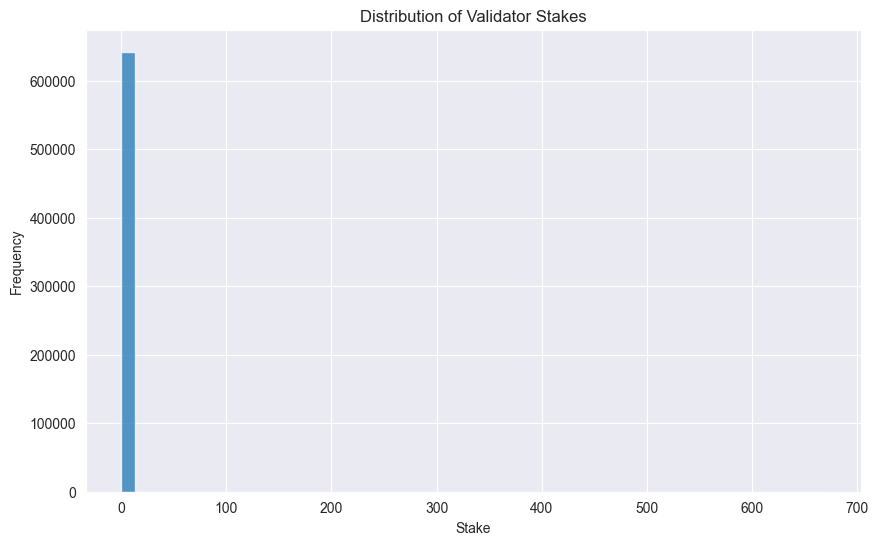

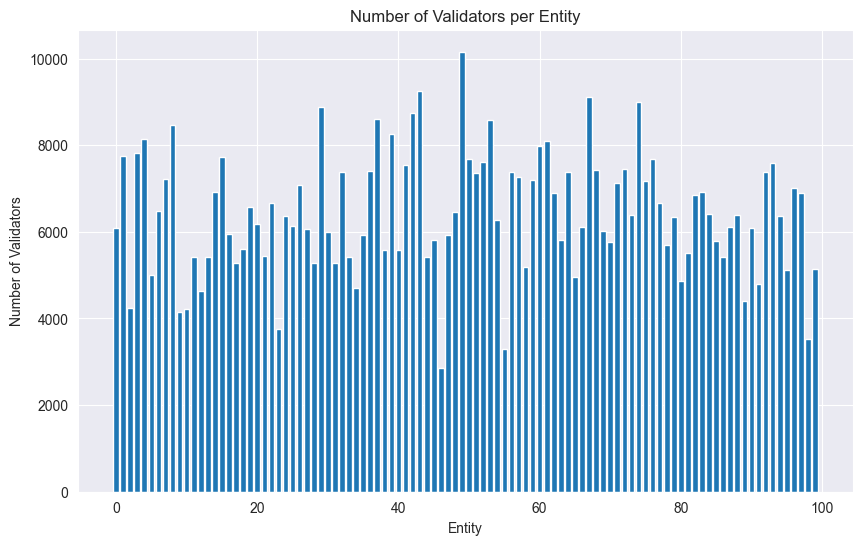

In [31]:
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np

# Calculate summary statistics
num_validators = len(validator_rewards)
average_stake = np.mean(validator_rewards)
median_stake = np.median(validator_rewards)
std_dev_stake = np.std(validator_rewards)

summary_statistics = {
    "Number of validators": num_validators,
    "Average stake": average_stake,
    "Median stake": median_stake,
    "Standard deviation of stake": std_dev_stake,
}

# Calculate entity statistics
validators_count_per_entity = [len(validators) for validators in validators_per_entity]
entity_values = np.array(validators_count_per_entity) * 32 + entity_rewards

# Print the summary statistics
print("\nSummary Statistics:")
for k, v in summary_statistics.items():
    print(f"{k}: {v}")

# Print the entity statistics
entity_statistics = list(zip(range(num_entities), validators_count_per_entity, entity_values))

print("\nEntity Statistics:")
print(tabulate(entity_statistics, headers=["Entity", "Validators", "Total Value"]))

# Plot the validator stakes
plt.figure(figsize=(10, 6))
plt.hist(validator_rewards, bins=50, alpha=0.75)
plt.title('Distribution of Validator Stakes')
plt.xlabel('Stake')
plt.ylabel('Frequency')
plt.show()

# Plot the number of validators per entity
plt.figure(figsize=(10, 6))
plt.bar(range(num_entities), validators_count_per_entity)
plt.title('Number of Validators per Entity')
plt.xlabel('Entity')
plt.ylabel('Number of Validators')
plt.show()

In [30]:
# Calculate the number of validators per entity
validators_count_per_entity = [len(validators) for validators in validators_per_entity]

# Calculate the stats
min_val = np.min(validators_count_per_entity)
max_val = np.max(validators_count_per_entity)
median_val = np.median(validators_count_per_entity)
avg_val = np.mean(validators_count_per_entity)

# Print the stats
print("Number of validators per entity:")
print(f"Minimum: {min_val}")
print(f"Maximum: {max_val}")
print(f"Median: {median_val}")
print(f"Average: {avg_val}")

Number of validators per entity:
Minimum: 2862
Maximum: 10158
Median: 6361.5
Average: 6425.54
